In [2]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report,roc_curve, auc, plot_roc_curve, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit, StratifiedKFold, cross_val_score
from sklearn.utils import resample
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE 
from collections import Counter

pred_path = "../files/SeizurePrediction/"
dect_path = "../files/SeizureDetection/"

In [3]:
def balance_data(data_x, data_y,verbose=False):
    if verbose: print('Original dataset shape %s' % Counter(data_y))
    sm = SMOTE()
    X_res, y_res = sm.fit_resample(data_x, data_y)
    if verbose: print('Resampled dataset shape %s' % Counter(y_res))
    return X_res, y_res

def scale_data(x):
    train_scaler = preprocessing.StandardScaler().fit(x)
    return train_scaler.transform(x)

def print_statistics(y_test, y_pred,i=None):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    PPV = tp / (tp+fp)
    f1 =  2*((PPV*sensitivity)/(PPV+sensitivity))
    print("{:^5d},{:^15.4f},{:^15.4f},{:^15.4f},{:^15.4f},{:^15.4f}".format(i,specificity,sensitivity,accuracy,PPV,f1))

def train_pred(X, y, save=False, dop=""):
    cv = StratifiedKFold(5,shuffle = True, random_state=2021534)
    tprs = []
    aucs = []
    
    originalclass = []
    predictedclass = []

    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(8,6))
    print("{:^5s},{:^15s},{:^15s},{:^15s},{:^15s},{:^15s}".format("fold","specificity","sensitivity",'accuracy','PPV','f1'))
    for i, (train, test) in enumerate(cv.split(X, y)):
        X_train, y_train = balance_data(X[train], y[train])
        scaler = preprocessing.StandardScaler().fit(X[train])
        X_train = scaler.transform(X_train)
        X_test, y_test = X[test], y[test]
        X_test = scaler.transform(X_test)
        class_model = GradientBoostingClassifier(n_estimators=200,max_features='sqrt',random_state=2021).fit(X_train, y_train)
#         y_pred = class_model.predict(X_test)
                
        y_hat = class_model.predict_proba(X_test)[:, 1]
        # Calculate the ROC Curves
        fpr, tpr, thresholds = roc_curve(y_test, y_hat)
        gmeans = np.sqrt(tpr * (1-fpr))
        
        ix = np.argmax(gmeans)
        y_pred = class_model.predict_proba(X_test)[:,1] >= thresholds[ix]
        ax.scatter(fpr[ix], tpr[ix], marker='o', color='red', alpha=0.3)
        originalclass.extend(y_test)
        predictedclass.extend(y_pred)
        
        viz = plot_roc_curve(class_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        # basic statistics
        print_statistics(y_test, y_pred,i)
        print_statistics(y_test, class_model.predict(X_test),i)
        
    print(classification_report(originalclass, predictedclass))
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax.legend(loc="lower right")
    if save:
        plt.savefig(os.path.join("./figures", "svm_rocaoc_{}_{}.pdf".format(dop,save)))
    plt.show()
    return aucs


In [21]:
data["result"][::3].to_numpy().shape

(896,)

========== Dog_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.6608     ,    0.7778     ,    0.6667     ,    0.1077     ,    0.1892     
  0  ,    0.9649     ,    0.1111     ,    0.9222     ,    0.1429     ,    0.1250     
  1  ,    0.6023     ,    0.5000     ,    0.5978     ,    0.0556     ,    0.1000     
  1  ,    0.9415     ,    0.1250     ,    0.9050     ,    0.0909     ,    0.1053     
  2  ,    0.4795     ,    0.7500     ,    0.4916     ,    0.0632     ,    0.1165     
  2  ,    0.9708     ,    0.0000     ,    0.9274     ,    0.0000     ,      nan      


<ipython-input-3-b196accb60a7>:18: RuntimeWarning: invalid value encountered in double_scalars
  f1 =  2*((PPV*sensitivity)/(PPV+sensitivity))


  3  ,    0.6608     ,    0.7500     ,    0.6648     ,    0.0938     ,    0.1667     
  3  ,    0.9649     ,    0.0000     ,    0.9218     ,    0.0000     ,      nan      


<ipython-input-3-b196accb60a7>:18: RuntimeWarning: invalid value encountered in double_scalars
  f1 =  2*((PPV*sensitivity)/(PPV+sensitivity))


  4  ,    0.4118     ,    0.7778     ,    0.4302     ,    0.0654     ,    0.1207     
  4  ,    0.9647     ,    0.1111     ,    0.9218     ,    0.1429     ,    0.1250     
              precision    recall  f1-score   support

         0.0       0.98      0.56      0.71       854
         1.0       0.07      0.71      0.13        42

    accuracy                           0.57       896
   macro avg       0.53      0.64      0.42       896
weighted avg       0.93      0.57      0.69       896



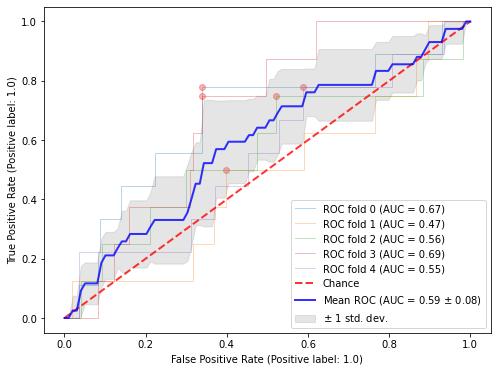

[0.673164392462638, 0.472953216374269, 0.5621345029239766, 0.6944444444444444, 0.5483660130718955]
0.5902125138554446
========== Dog_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.8596     ,    0.8000     ,    0.8549     ,    0.3243     ,    0.4615     
  0  ,    0.9607     ,    0.5333     ,    0.9275     ,    0.5333     ,    0.5333     
  1  ,    0.7865     ,    0.9333     ,    0.7979     ,    0.2692     ,    0.4179     
  1  ,    0.9382     ,    0.5333     ,    0.9067     ,    0.4211     ,    0.4706     
  2  ,    0.7135     ,    0.9333     ,    0.7306     ,    0.2154     ,    0.3500     
  2  ,    0.9551     ,    0.6000     ,    0.9275     ,    0.5294     ,    0.5625     
  3  ,    0.8202     ,    0.8000     ,    0.8187     ,    0.2727     ,    0.4068     
  3  ,    0.9438     ,    0.4667     ,    0.9067     ,    0.4118     ,    0.4375     
  4  ,    0.8079     ,    0.8667     ,    0.8125     ,    0.2766     ,  

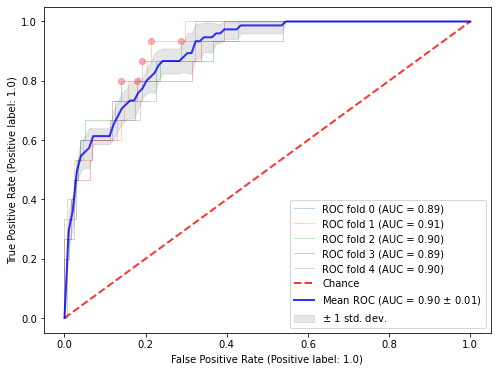

[0.8876404494382022, 0.9142322097378277, 0.8992509363295881, 0.8902621722846442, 0.9013182674199622]
0.898540807042045
========== Dog_3_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9141     ,    0.8846     ,    0.9126     ,    0.3433     ,    0.4946     
  0  ,    0.9922     ,    0.5769     ,    0.9721     ,    0.7895     ,    0.6667     
  1  ,    0.9688     ,    0.7692     ,    0.9591     ,    0.5556     ,    0.6452     
  1  ,    0.9922     ,    0.6538     ,    0.9758     ,    0.8095     ,    0.7234     
  2  ,    0.9258     ,    0.8462     ,    0.9219     ,    0.3667     ,    0.5116     
  2  ,    0.9922     ,    0.6923     ,    0.9777     ,    0.8182     ,    0.7500     
  3  ,    0.8789     ,    0.8800     ,    0.8790     ,    0.2619     ,    0.4037     
  3  ,    0.9902     ,    0.6800     ,    0.9758     ,    0.7727     ,    0.7234     
  4  ,    0.9766     ,    0.8800     ,    0.9721     ,    0.6471     , 

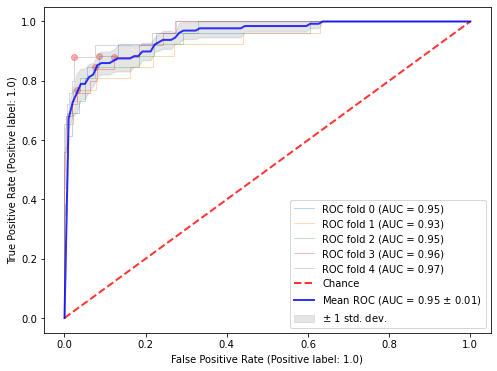

[0.94921875, 0.9276592548076923, 0.9544771634615384, 0.9590625, 0.97359375]
0.9528022836538461
========== Dog_4_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.7972     ,    0.7143     ,    0.7882     ,    0.3012     ,    0.4237     
  0  ,    0.8916     ,    0.4857     ,    0.8474     ,    0.3542     ,    0.4096     
  1  ,    0.7692     ,    0.8571     ,    0.7788     ,    0.3125     ,    0.4580     
  1  ,    0.8811     ,    0.6571     ,    0.8567     ,    0.4035     ,    0.5000     
  2  ,    0.7448     ,    0.8857     ,    0.7601     ,    0.2981     ,    0.4460     
  2  ,    0.8741     ,    0.6286     ,    0.8474     ,    0.3793     ,    0.4731     
  3  ,    0.7203     ,    0.8235     ,    0.7312     ,    0.2593     ,    0.3944     
  3  ,    0.8916     ,    0.3824     ,    0.8375     ,    0.2955     ,    0.3333     
  4  ,    0.7273     ,    0.8235     ,    0.7375     ,    0.2642     ,    0.4000     
  4  ,   

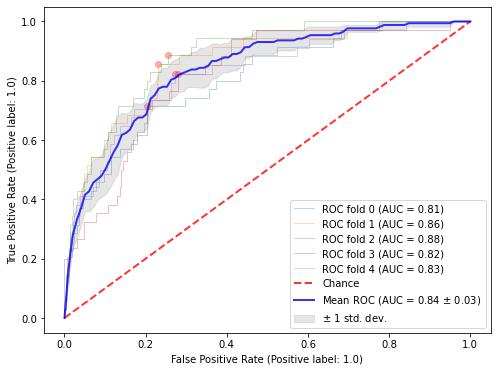

[0.8066933066933066, 0.8587412587412587, 0.8837162837162837, 0.8187988482106129, 0.8268202385849445]
0.8389539871892813
========== Dog_5_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9187     ,    1.0000     ,    0.9240     ,    0.4583     ,    0.6286     
  0  ,    0.9938     ,    0.7273     ,    0.9766     ,    0.8889     ,    0.8000     
  1  ,    0.9688     ,    1.0000     ,    0.9708     ,    0.6875     ,    0.8148     
  1  ,    0.9750     ,    0.8182     ,    0.9649     ,    0.6923     ,    0.7500     
  2  ,    0.9625     ,    1.0000     ,    0.9649     ,    0.6471     ,    0.7857     
  2  ,    0.9875     ,    0.7273     ,    0.9708     ,    0.8000     ,    0.7619     
  3  ,    0.9187     ,    0.9091     ,    0.9181     ,    0.4348     ,    0.5882     
  3  ,    0.9812     ,    0.7273     ,    0.9649     ,    0.7273     ,    0.7273     
  4  ,    0.9250     ,    1.0000     ,    0.9294     ,    0.4545     ,

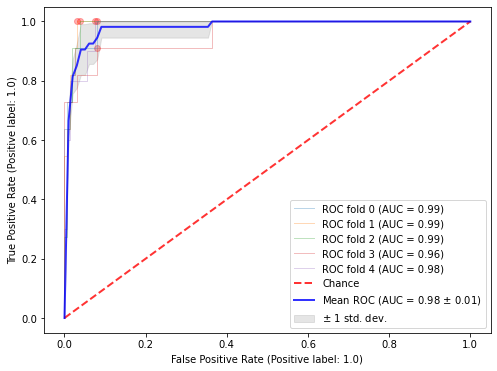

[0.9880681818181818, 0.9920454545454546, 0.9897727272727272, 0.9568181818181818, 0.9825]
0.981840909090909
========== Patient_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    0.8333     ,    0.9600     ,    1.0000     ,    0.9091     
  1  ,    0.8947     ,    1.0000     ,    0.9200     ,    0.7500     ,    0.8571     
  1  ,    1.0000     ,    0.6667     ,    0.9200     ,    1.0000     ,    0.8000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.000

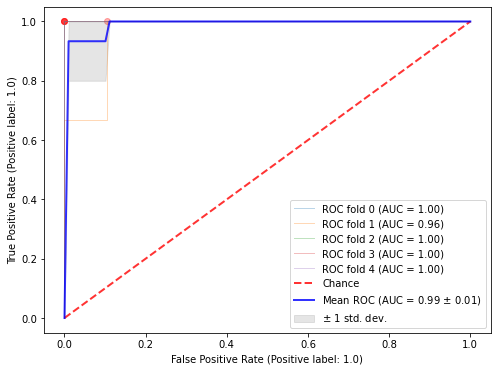

[1.0, 0.9649122807017544, 1.0, 1.0, 1.0]
0.9929824561403509
========== Patient_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9375     ,    1.0000     ,    0.9545     ,    0.8571     ,    0.9231     
  0  ,    0.9375     ,    0.8333     ,    0.9091     ,    0.8333     ,    0.8333     
  1  ,    0.7500     ,    1.0000     ,    0.8182     ,    0.6000     ,    0.7500     
  1  ,    1.0000     ,    0.5000     ,    0.8636     ,    1.0000     ,    0.6667     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    0.8571     ,    0.9545     ,    1.0000     ,    0.9231     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    0.8571     ,    0.9545     ,    1.0000     ,    0.9231     
  4  ,    0.9333     ,    1.0000     ,    0.9545     ,    0.8750     ,    0.9333     
  4  ,    1.0000     ,    0.7143     ,  

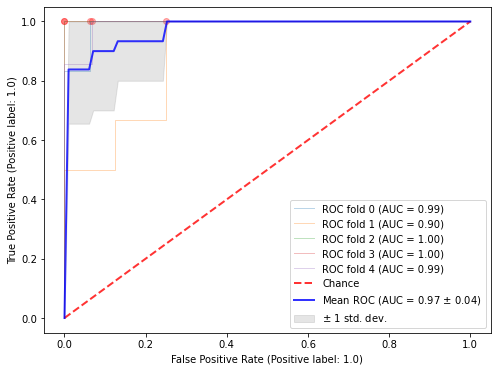

[0.9895833333333334, 0.8958333333333333, 1.0, 1.0, 0.9904761904761905]
0.9751785714285713


In [22]:
file_list = [f for f in Path(pred_path).glob("*_reduced.csv")]
for f in file_list:
    data = pd.read_csv(f.resolve())
    sample = f.name.split('.')[0]
    print('='*10, sample ,'='*10)
    data_y = data["result"][::3].to_numpy()
    data_x = data.loc[::3, data.columns != 'result'].to_numpy()
    aucs = train_pred(data_x, data_y,save=sample)
    print(aucs)
    print(np.mean(aucs))